In [1]:
import torch
print(torch.cuda.is_available())
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import scanpy as sc
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(4,4)
from scanpy import AnnData

True


In [2]:
import os
os.listdir('DATA/')

['CytAssist_FFPE_Mouse_Brain_Rep2_raw_feature_bc_matrix.tar',
 'CytAssist_FFPE_Mouse_Brain_Rep2_spatial.tar.gz',
 'best_model_03112025_model.pth',
 'mousebrain1',
 'mousebrain2',
 'mousebrain3',
 'mousebrain4',
 'mousebrain5',
 'mousebrain6',
 'mousebrain7',
 'raw_feature_bc_matrix',
 'spatial']

In [3]:
import h5py

# Open the file and check its keys
file_path ='DATA/mousebrain4/CytAssist_FFPE_Mouse_Brain_Rep2_filtered_feature_bc_matrix.h5'
with h5py.File(file_path, "r") as f:
    print(list(f.keys()))

['matrix']


In [4]:
adata = sc.read_10x_h5('DATA/mousebrain4/CytAssist_FFPE_Mouse_Brain_Rep2_filtered_feature_bc_matrix.h5')

In [5]:
adata.shape

(2235, 19465)

In [6]:
spatial_data=pd.read_csv('DATA/spatial/tissue_positions.csv').set_index('barcode')
for c in spatial_data.columns:
    adata.obs[c]=spatial_data[c]
adata.obs['pxl_row_in_fullres']*=-1
spatial_coords = adata.obs[['pxl_col_in_fullres', 'pxl_row_in_fullres']].values

# Assign to .obsm['spatial']
adata.obsm['X_spatial'] = spatial_coords

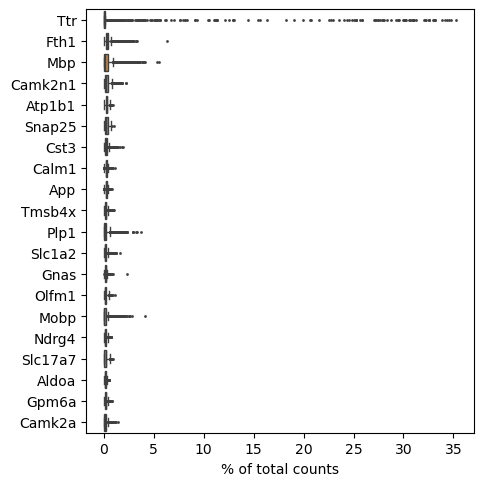

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [8]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [9]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

In [10]:
adata.var_names_make_unique()

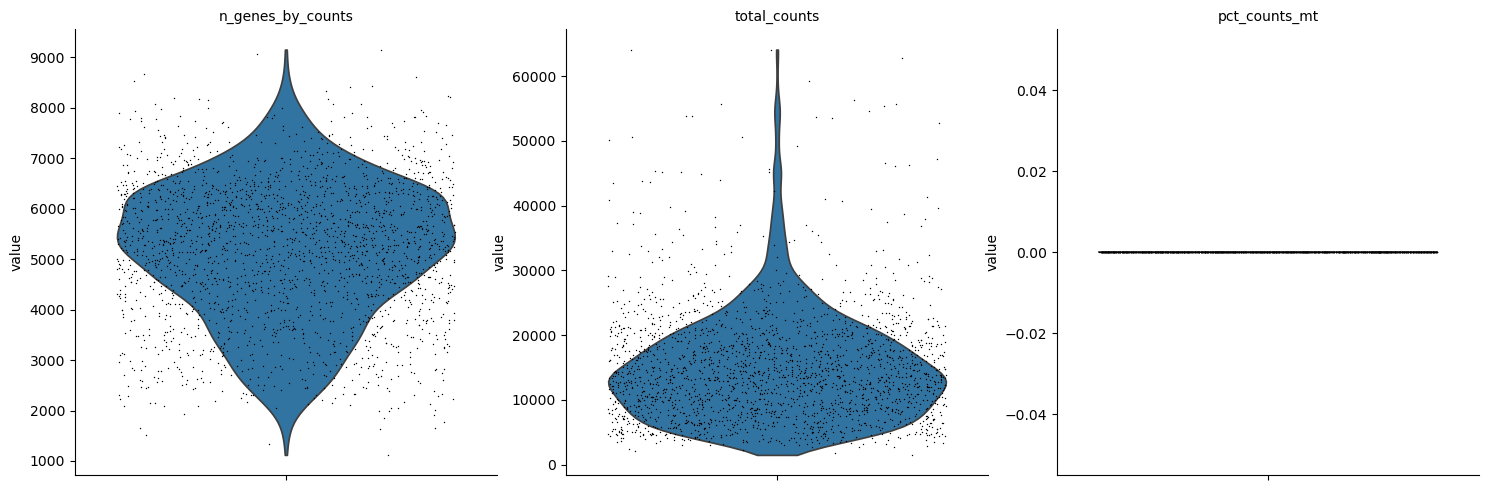

In [11]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

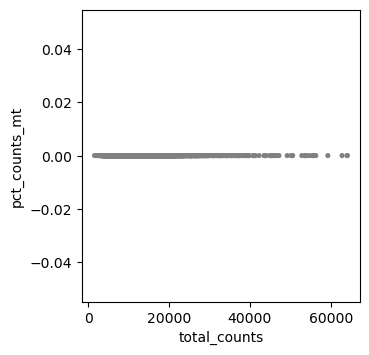

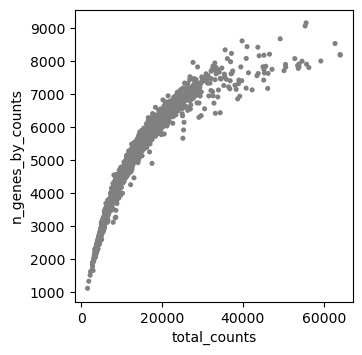

In [12]:
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

In [13]:
adata = adata[adata.obs.total_counts < 30000, :]

In [15]:
sc.pp.normalize_total(adata, target_sum=1e4)

In [16]:
sc.pp.log1p(adata)

In [17]:
sc.pp.scale(adata, max_value=10)

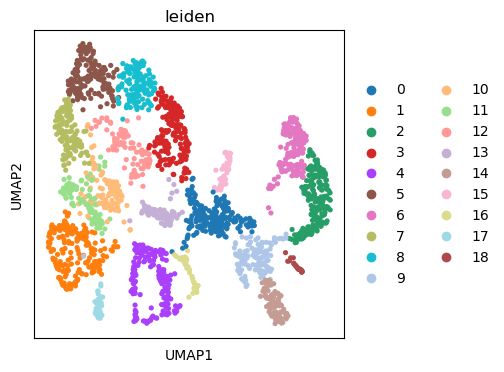

In [18]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.leiden(adata)
sc.tl.umap(adata)
sc.pl.umap(adata,color='leiden')

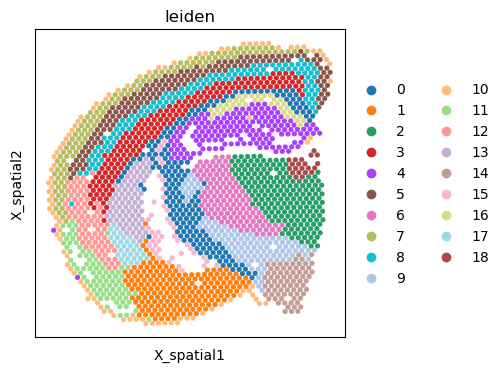

In [19]:

sc.pl.embedding(adata, color='leiden',basis='X_spatial')

In [21]:
adata.write_h5ad('visium_mouse.h5ad')

Epoch 0, Loss: 1851.4266357421875
Epoch 20, Loss: 103.41936492919922
Epoch 40, Loss: 39.7396125793457
Epoch 60, Loss: 28.783893585205078
Epoch 80, Loss: 22.612329483032227
Epoch 100, Loss: 12.636815071105957
Epoch 120, Loss: 6.938579559326172
Epoch 140, Loss: 7.8123860359191895
Epoch 160, Loss: 8.680837631225586
Epoch 180, Loss: 5.840448379516602


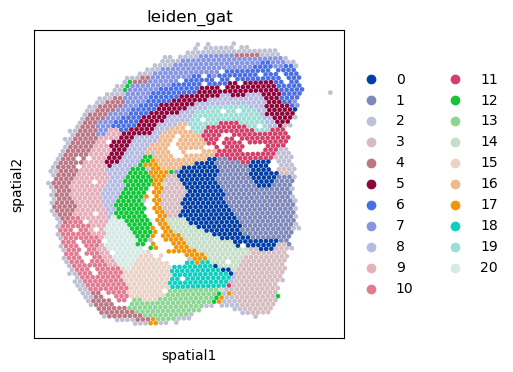

In [22]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc

# Assuming adata is your AnnData object
# Step 1: Preprocess the data
# sc.pp.normalize_total(adata, target_sum=1e4)
# sc.pp.log1p(adata)
# sc.pp.pca(adata, n_comps=50)  # Reduce dimensionality
X = adata.obsm['X_pca']  # Node features (PCA components)
spatial_coords = adata.obsm['X_spatial']  # Spatial coordinates

# Step 2: Construct the graph
# Create a k-NN graph based on spatial coordinates (k=6 neighbors)
adj_matrix = kneighbors_graph(spatial_coords, n_neighbors=6, mode='connectivity', include_self=False)
edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)  # Edge indices

# Create PyTorch Geometric Data object
data = Data(
    x=torch.tensor(X.copy(), dtype=torch.float),  # Use .copy() to avoid negative strides
    edge_index=edge_index,  # Edge indices
    num_nodes=X.shape[0]
)

# Step 3: Define the GAT model
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=0.6)
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

# Initialize the model
model = GAT(in_channels=50, hidden_channels=16, out_channels=16)  # Output 16-dimensional embeddings
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Step 4: Train the model (simplified unsupervised objective)
model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    # Use a contrastive loss or reconstruction loss (simplified here)
    loss = F.mse_loss(out, torch.zeros_like(out))  # Placeholder; replace with a proper loss
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Step 5: Get embeddings and cluster
model.eval()
with torch.no_grad():
    embeddings = model(data).numpy()

# Cluster the embeddings (e.g., using Scanpy's Leiden)
adata.obsm['GAT_embeddings'] = embeddings
sc.pp.neighbors(adata, use_rep='GAT_embeddings')
sc.tl.leiden(adata, key_added='leiden_gat')
sc.pl.embedding(adata, basis='spatial', color='leiden_gat')

In [23]:
sc.tl.rank_genes_groups(adata,groupby='leiden')


In [24]:
# for i in adata.obs['leiden'].unique():
#     print(i)
#     sc.pl.embedding(adata, basis='spatial', color=adata.uns['rank_genes_groups']['names'][i][:1])

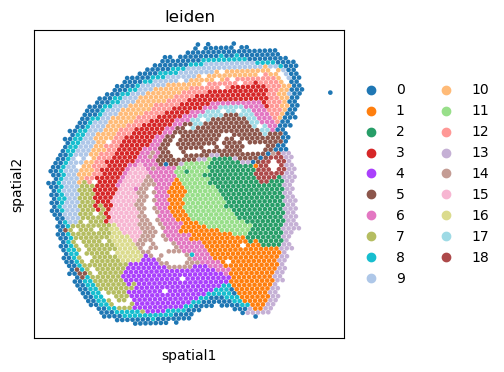

In [25]:
sc.pl.embedding(adata, basis='spatial', color='leiden')
# sc.pl.embedding(adata, basis='spatial', color='Sema5a')

In [26]:
os.listdir('DATA/spatial')

['aligned_fiducials.jpg',
 'aligned_tissue_image.jpg',
 'cytassist_image.tiff',
 'detected_tissue_image.jpg',
 'scalefactors_json.json',
 'spatial_enrichment.csv',
 'tissue_hires_image.png',
 'tissue_lowres_image.png',
 'tissue_positions.csv']

Training the model on your image...
Epoch [20/300], Loss: 0.1969
Epoch [40/300], Loss: 0.1739
Epoch [60/300], Loss: 0.1609
Epoch [80/300], Loss: 0.1467
Epoch [100/300], Loss: 0.1360
Epoch [120/300], Loss: 0.1295
Epoch [140/300], Loss: 0.1230
Epoch [160/300], Loss: 0.1167
Epoch [180/300], Loss: 0.1092
Epoch [200/300], Loss: 0.1031
Epoch [220/300], Loss: 0.0971
Epoch [240/300], Loss: 0.0885
Epoch [260/300], Loss: 0.1086
Epoch [280/300], Loss: 0.0867
Epoch [300/300], Loss: 0.0771
Plotting detected structures...


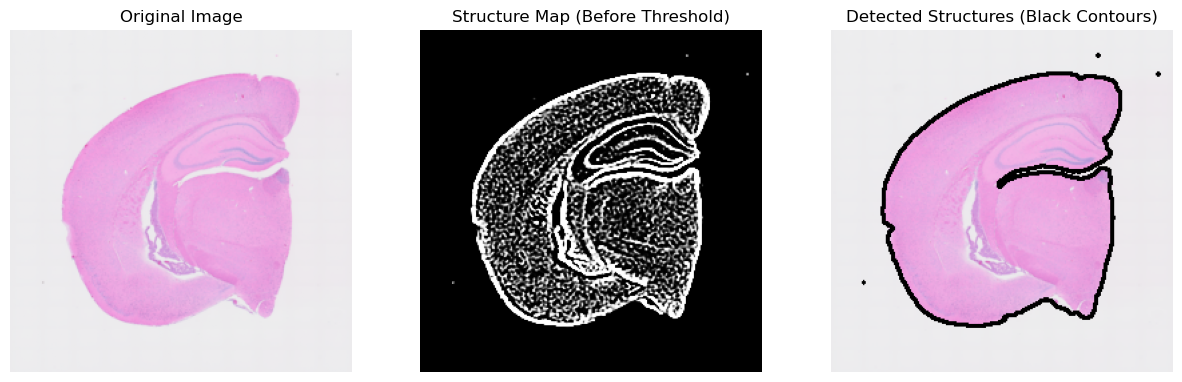

In [41]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader


class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = None
        if in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        return out

class AdvancedStructureDetector(nn.Module):
    def __init__(self):
        super(AdvancedStructureDetector, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(2, 2)
        
        self.res1 = ResidualBlock(32, 64)
        self.res2 = ResidualBlock(64, 128)
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        self.conv_final = nn.Conv2d(128, 1, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.res1(x)
        x = self.res2(x)
        
        x = self.upsample(x)
        x = self.conv_final(x)
        return torch.sigmoid(x)

Custom Dataset with Improved Mask
class SingleImageDataset(Dataset):
    def __init__(self, image_path, size=(256, 256)):
        self.size = size
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor(),
        ])
        
        # load and preprocess the image
        image = Image.open(image_path).convert('RGB')
        self.image = self.transform(image)
        
        # mask generation for tissue image
        img_np = np.array(image.resize(size))
        gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
        #thresholding to detect structures in tissue
        mask = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                     cv2.THRESH_BINARY_INV, 11, 2)
        #edge detection for sharper boundaries
        edges = cv2.Canny(gray, 100, 200)
        mask = cv2.bitwise_or(mask, edges)  # Combine threshold and edges
        self.mask = torch.tensor(mask / 255.0, dtype=torch.float32).unsqueeze(0)  # (1, H, W)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return self.image, self.mask


def train_model(model, dataloader, num_epochs=100, device='cpu'):
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    model.train()
    for epoch in range(num_epochs):
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, masks)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 20 == 0:  # Print every 20 epochs
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

def detect_and_plot(model, image_path, device='cpu'):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
    ])
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    original_image = input_tensor.squeeze().permute(1, 2, 0).cpu().numpy()
    
    model.eval()
    with torch.no_grad():
        structure_map = model(input_tensor).squeeze().cpu().numpy()

    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(structure_map, cmap='gray')
    plt.title("Structure Map (Before Threshold)")
    plt.axis('off')
    

    structure_map = (structure_map > 0.35).astype(np.uint8)
    contours, _ = cv2.findContours(structure_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    overlay_image = (original_image * 255).astype(np.uint8)
    overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_RGB2BGR)
    cv2.drawContours(overlay_image, contours, -1, (0, 0, 0), 2)  # Black contours
    overlay_image = cv2.cvtColor(overlay_image, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 3, 3)
    plt.imshow(overlay_image)
    plt.title("Detected Structures (Black Contours)")
    plt.axis('off')
    
    plt.show()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_path = 'DATA/spatial/tissue_hires_image.png'

model = AdvancedStructureDetector().to(device)

dataset = SingleImageDataset(image_path)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False)

train_model(model, dataloader, num_epochs=300, device=device)
detect_and_plot(model, image_path, device=device)